In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
(train_set, train_label), (test_set, test_label) = mnist.load_data()
train_set, train_label = train_set[:20000], train_label[:20000]

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
train_set.shape

(20000, 28, 28)

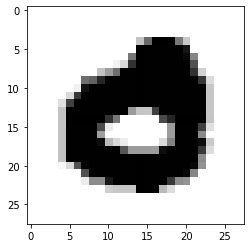

In [ ]:
plt.imshow(train_set[1999][:,:], cmap = plt.cm.binary)

In [ ]:
#Reshape the images as a 784d vector
train_set = train_set.reshape(20000,-1)/255

In [ ]:
#Binarising the data for use in Bernoulli 
train_set[train_set < 0.5] = 0
train_set[train_set > 0.5] = 1 

# Section 1. Implementing a Multi Dimensional Bernoulli random variable

Approach here is to treat each image as a vector of dimension 784. Since we normalised the image, each pixel in the image will be in the range [0,1]

Assume that for a given image vector $X_i$, it has pixels $$X_i = [x_{i1}, x_{i2}, x_{i3}, .... , x_{id}]$$Our bernoulli random variable follows the distribution $$p(x_j | \theta_j) = \theta_j^{x_j} (1 - \theta_j)^{1 - x_j}$$So for each pixel belonging to $X_i$, it follows the above distribution. The main assumption again that we follow is that the pixels in a given image are independent of each other. So by the rule of independence, we have $$\begin{equation}
p(X_i | \theta) = \Pi_{j=1}^d p(x_{ij} | \theta_j)
\end{equation}$$



Now that we know the probability distribution for a single image, we compute the total data likelihood which is the product of the above distribution for each image i.e. $$\begin{equation} p(D| \theta) = \Pi_{i = 1}^N p(X_i | \theta) \end{equation}$$
So we have $$\begin{equation} p(D | \theta) = \Pi_{i = 1}^N \Pi_{j = 1}^d \theta^{x_{ij}} (1 - \theta)^{1 - x_{ij}} \end{equation} $$

Now you can take the log likelihood of the data and differentiate w.r.t $\theta$ to get the MLE estimate of the bernoulli random variable for the mnist dataset. After differentiation we get $$\begin{equation} \theta_j^{MLE} = \frac{\Sigma_{i = 1}^N x_{ij}}{N} \end{equation}$$ which intuitively means that the $j^{th}$ component of $\theta^{MLE}$ is simply the sum of the $j^{th}$ pixel value across all images. 

Therefore this says that if we want to say get the Bernoulli Model for the MNIST, we want the $\theta$ to be the mean of each pixel across all images.

In [ ]:
#Complete the code to get the MLE estimate of theta for mnist
theta_MLE = np.mean(train_set, axis = 0)

0.0


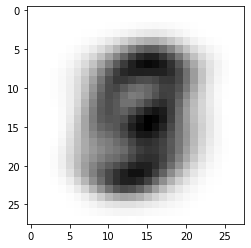

In [ ]:
#Visualisation of the MLE estimate
theta_MLE = theta_MLE.reshape(28,28)*255
plt.imshow(theta_MLE, cmap = plt.cm.binary)

# Section 2. Implementing KMeans on MNIST to cluster data

So we have studied KMeans as a very intuitive approach to clustering data. Suppose we want to categorize each image into a specific cluster. How do we do that ? 

In [ ]:

def calcSqDistances(X,Kmus):
  #N = np.shape(X)[0]
  #K = np.shape(Kmus)[0]
  #dist_array = np.zeros((N,K), dtype = np.float64)
  #for i in range(N):
   #for j in range(K):
    #dist_array[i,j] = np.linalg.norm(X[i] - Kmus[j])
  return  ((-2 * X @ Kmus.T + np.sum(Kmus * Kmus, axis = 1).T).T + np.sum(X * X, axis = 1)).T

In [ ]:
def determineRnk(sqDmat):
  low = np.argmin(sqDmat, axis = 1)
  rnk = np.identity(sqDmat.shape[1])[low]
  return rnk

In [ ]:
def recalcMus(X, Rnk):
    Kmus = np.zeros((len(Rnk[0]), 2))
    return (np.divide(X.T.dot(Rnk), np.sum(Rnk, axis=0))).T

In [ ]:
def runKMeans(K):
    X = train_set
    N = np.shape(X)[0]
    D = np.shape(X)[1]

    Kmus = np.zeros((K,D))

    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    for itr in range(1000):
        distmat = calcSqDistances(X, Kmus)

        rnk = determineRnk(distmat)

        mus_old = Kmus
        Kmus = recalcMus(X, rnk)
        if np.sum(np.abs(mus_old.reshape((-1,1)) - Kmus.reshape((-1,1)))) < 1e-6:
            break

    return Kmus

# We can see which cluster roughly represents which digit. 

In [ ]:
# from the student copy of project1 notebook
def get_cluster_plot(Kmus, rows = 2): 
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(rows,5, figsize = (15,9))
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(28,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Cluster {i + 1}')

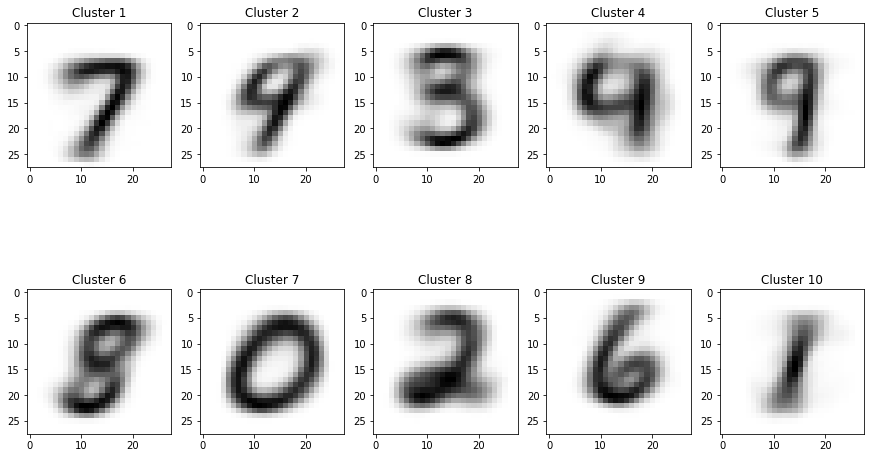

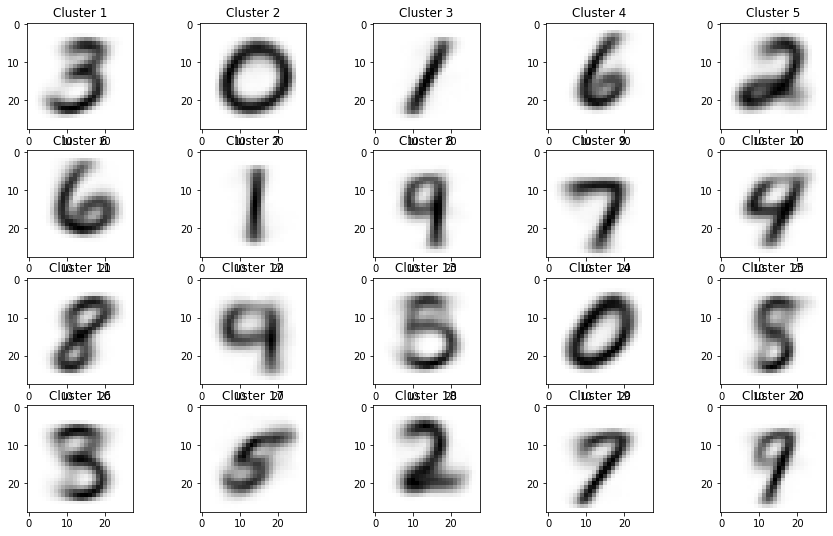

In [ ]:
Kmus_10 = runKMeans(10)
Kmus_20 = runKMeans(20)
#print(Kmus_10)
#print(Kmus_20)
get_cluster_plot(Kmus_10) #Get cluster representation for K = 10 clusters
get_cluster_plot(Kmus_20, 4) #Get cluster representation for K = 20 clusters

In [ ]:
Kmus_10.shape


(10, 784)

# 3. Implementation of a Mixture of Bernoulli Distributions

We have seen the performance of a single Bernoulli Distribution on the dataset. We saw it was not very good. On the other hand, using KMeans, we saw that same digits are having different cluster centers based on the writing style. Ex : In the image above, we can see that 0 is associated with clusters 5,7,13 and so on. So we hypothesise that a single digit cannot be entirely sampled from a single distribution and hence a mixture model maybe able to better explain the datas. 

Let us assume that our model is actually a Mixture of Multivariate Bernoulli random variable. For now, let us assume that the model consists of 10 multivariate bernoulli distributions. In this case, given a vector of pixel values, we don't know which cluster it belongs to. So let $z = \{1,2,3,4,5,...,10\}$ represent the cluster numbers. Each cluster is a multivariate bernoulli random variable and hence $$\begin{equation} p(x | z = k) = \prod_{j = 1}^d \theta_{kj}^{x_j} (1 - \theta_{kj})^{1 - x_j}  \\ ∀ k ∈ \{1,2,...,10\} \end{equation} $$ where $p(z = k) = \pi_k$
Using this we write $$p(x,z) = p(x | z = k) p(z = k) = \prod_{k = 1}^{10} (\pi_k p(x | \theta_k))^{z_k} $$ where $z_k = 1$ if the data point belongs to cluster k. This is the one hot encoding trick discussed in class. Now given a dataset $D = \{x_1, x_2, x_3, ...., x_N\}$, the likelihood can be written as $$p(X, Z) = \prod_{i = 1}^N p(x_i, z) = \prod_{i = 1}^N \prod_{k = 1}^{10} (\pi_k p(x_i | \theta_k))^{z_{ik}}$$ This is the total data likelihood that we want to maximize in the presence of unknown/latent variables. Taking the log of this, we have $$log(p(X,Z)) = \sum_{i = 1}^N \sum_{k = 1}^{10} z_{ik} log(p(x_i | z = k) = \sum_{i = 1}^N \sum_{k = 1}^{10} z_{ik} (log(\pi_k) + \sum_{j = 1}^d (x_{ij}log(\theta_{kj}) + (1 - x_{ij})log(1 - \theta_{kj})))$$ This is the function that we would like to maximise and get the optimal values of $\theta$ and $\pi$. But since the latent variables are unknow, what we do is we take the expectation of this expression wrt observed data $X$ and some initial guess for the parameters that we want to find $\theta$ and $\pi$. The only expression above that depends on the latent variable is $z_{ik}$ and since this is a one hot encoding variable, we know that $$E[z_{ik} | X; \theta^o, \pi^o] = P(z_{ik} = k | X; \theta^o, \pi^o)$$ Applying Bayes Theorem, we have $$P(z_{ik} = k | X; \theta^o, \pi^o) = \frac{P(X | z_{ik} = k;  \theta^o, \pi^o) P(z_{ik} = k)}{\sum_{k = 1}^{10} P(X | z_{ik} = k;  \theta^o, \pi^o) P(z_{ik} = k)}$$ from which we have $$ \gamma_{ik} = \frac{\pi_k^o P(x_i | z = k; \theta_k ^o)}{\sum_{m = 1}^{10} \pi_m^o P(x_i | z = m; \theta_m ^ o)} $$ This is the E step of the EM algorithm. Now we have the expectation of the total data log likelihood as $$Q(\theta, \pi; \theta^o, \pi^o ) = E[log(p(X,Z))] = \sum_{i = 1}^N \sum_{k = 1}^{10} \gamma_{ik} (log(\pi_k) + \sum_{j = 1}^d (x_{ij}log(\theta_{kj}) + (1 - x_{ij})log(1 - \theta_{kj})))$$ Now our aim in the M step is to find optimal parameters $\theta$ and $\pi$ that maximize the Q function $Q(\theta, \pi; \theta^o, \pi^o )$ subject to constraints $\sum_{k = 1}^{10} \pi_k = 1$ The result of the optimisation process is as follows 
$$\pi_k^{o + 1} = \frac{\sum_{i = 1}^N \gamma_{ik}}{N}$$ and $$\theta_k^{o + 1} = \frac{\sum_{i = 1}^N \gamma_{ik} x_{i}}{\sum_{i = 1}^N \gamma_{ik}}$$

Thus, we have arrived at the end of M step. Now we repeat the process untill the change in parameters in negligible. So overall, the EM algorithm for Mixture of Bernoulli can be summarised as follows :- 
1. Start with a guess of parameters $\pi^o$ and $\theta^o$ where $\sum_{k = 1}^{10} \pi^o = 1$. 
2. E step : Compute $\gamma_{ik}$ for $i \in \{1,2,...,N\}$ and $k \in \{1,2,3...,10\}$ 
$$\gamma_{ik} = \frac{\pi_k^o P(x_i | z = k; \theta_k ^o)}{\sum_{m = 1}^{10} \pi_m^o P(x_i | z = m; \theta_m ^ o)} $$
3. M step: Find the next iteration values of parameters $\pi^{o + 1}$ and $\theta^{o + 1}$ $$\pi_k^{o + 1} = \frac{\sum_{i = 1}^N \gamma_{ik}}{N}$$ $$\theta_k^{o + 1} = \frac{\sum_{i = 1}^N \gamma_{ik} x_{i}}{\sum_{i = 1}^N \gamma_{ik}}$$

Using this framework, lets try to build a mixture model for the dataset.

In [ ]:
def bernoulli_prob(theta, X):
    mat_happening = theta ** X
    mat_nothappening = (1- theta)**(1-X)
    return np.prod(mat_happening * mat_nothappening, axis = 1)

def calcRespons(data, pi_k, theta, k, N):
    gamma= np.zeros((N,k), dtype = np.float64)
    for i in range(k):
        gamma[:, i] = bernoulli_prob(theta[i], data) * pi_k[i]
    gamma = np.divide(gamma, np.sum(gamma, axis = 1, keepdims= True))
    return gamma

def calcParams(data, gamma, N):
    pi_k = np.sum(gamma, axis = 0) / N 
    theta_k = np.divide(gamma.T @ data , np.sum(gamma, axis=0, keepdims=True).T)
    return pi_k, theta_k
    
def train_EM_MOB(x , pi, theta, K = 10): 
    '''
    :input arguments ---> data set, mixture probabilities, initial cluster locations and number of mixtures
    : Implement the EM algorithm for Mixture of Bernoulli random variables
    : HINT -> We strongly recommend to avoid two nested for loops. Try vectorising your code. 
    : A simple example of vectorisation is as follows :- 
    : Assume you have two vectors a and b. Suppose you want to find out the dot product of a and b. 
    : There are two ways -> 1. sum = 0 ; for i in range(len(a)): sum += a[i]*b[i] 
    : 2. sum = a.T @ b
    : The second method uses the matrix properties to get the same result as first. This is the main idea. 
    : Also it is a good idea to try out your own code with a small minibatch of data instead of the full data. 
    '''
    N = np.shape(x)[0]
    
    pi_old = pi
    theta_old = theta
    for itr in range(100):
        
      # E -step
        gamma = calcRespons(x, pi_old, theta_old, K, N)
      
      # M - step
        pi_temp , theta_temp = calcParams(x, gamma, N)
      #theta_k = np.zeros((K, np.shape(x)[1]))
      #for k in range(K): 
        #theta_k[k] = np.divide((np.dot(gamma.T, x))[k], np.sum(gamma[:,k]))
        
        if np.sum(np.abs(theta_old.reshape((-1, 1)) - theta_temp.reshape((-1, 1))))< 1e-2:
            break
        pi_old = pi_temp
        theta_old = theta_temp
      
    
    return pi_old , theta_old

In [ ]:
train = train_set
#Initialise the P(z = k) = $$\pi_k$$
pi = np.asarray([0.1] * 10)
#Initialise theta
theta = np.random.uniform(0.1, 0.5, (10,784))
#First try out with a small dataset
#pi_new, theta_new = train_EM_MOB(train[:500] , pi , theta)
#After ensuring it works as expected, run on full dataset
pi_new, theta_new = train_EM_MOB(train , pi, theta)

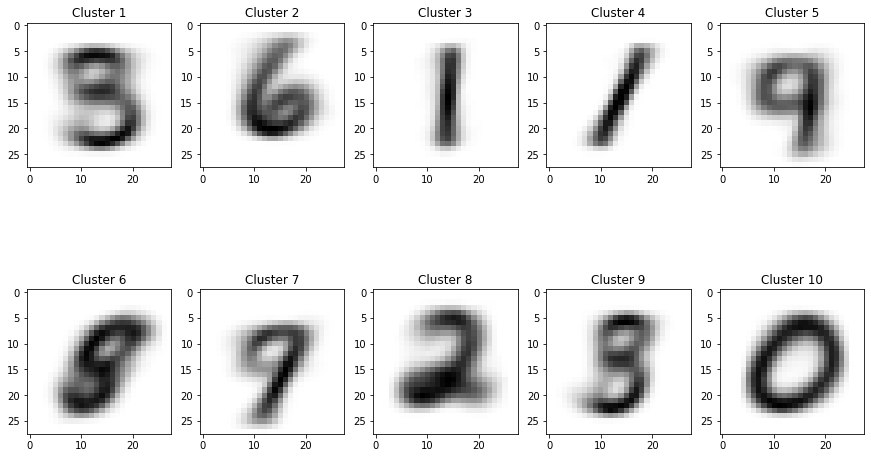

In [ ]:
#Visualise the 10 clusters that you obtained
get_cluster_plot(theta_new) #Get the cluster representation for a mixture model with 10 mixtures